In [14]:
import kagglehub
import numpy as np
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf

import matplotlib as plt

In [3]:
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/kennethwan/.cache/kagglehub/datasets/uciml/sms-spam-collection-dataset/versions/1


In [4]:
# Load and preprocess dataset
dataset_path = "/kaggle/input/sms-spam-collection-dataset/spam.csv"
dataset_path = path + "/spam.csv"

with open(dataset_path, 'r', encoding='latin-1') as f:
    reader = csv.reader(f)
    rows = list(reader)

if rows[0][0].lower() == "v1":
    rows = rows[1:]

data = np.array([[r[0], r[1]] for r in rows], dtype=object)
labels = data[:, 0]
messages = data[:, 1]

labels = np.where(labels == "spam", 1, 0)
print(labels.shape)
print(messages.shape)

(5572,)
(5572,)


In [5]:
# Split and vectorize dataset
X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

print("Vectorized shape:", X_train_vec.shape)

Vectorized shape: (4457, 7735)


In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

train_enc = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="tf"
)

test_enc = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors="tf"
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((
    dict(train_enc),
    y_train
)).shuffle(1000).batch(16)

test_ds = tf.data.Dataset.from_tensor_slices((
    dict(test_enc),
    y_test
)).batch(16)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [9]:
model.fit(train_ds, validation_data=test_ds, epochs=2)

logits = model.predict(test_ds).logits
preds = tf.argmax(logits, axis=1).numpy()

acc = accuracy_score(y_test, preds)
prec, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary")

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", recall)
print("F1:", f1)

Epoch 1/2
279/279 [==============================] - 1182s 4s/step - loss: 0.0727 - accuracy: 0.9794 - val_loss: 0.0398 - val_accuracy: 0.9892
Epoch 2/2
70/70 [==============================] - 75s 1s/step
Accuracy: 0.9946188340807175
Precision: 0.9864864864864865
Recall: 0.9733333333333334
F1: 0.9798657718120806


In [18]:
y_pred = np.argmax(logits, axis=1)

df_errors = pd.DataFrame({
    "text": X_test,
    "true": y_test,
    "pred": y_pred
})

df_errors["correct"] = df_errors["true"] == df_errors["pred"]

mistakes = df_errors[df_errors["correct"] == False]
mistakes.head(20)

,text,true,pred,correct
319,Total video converter free download type this ...,0,1,False
522,Hello darling how are you today? I would love ...,1,0,False
652,thesmszone.com lets you send free anonymous an...,1,0,False
1031,Would you like to see my XXX pics they are so ...,1,0,False
1066,"Do you ever notice that when you're driving, a...",1,0,False
1074,We are pleased to inform that your application...,0,1,False


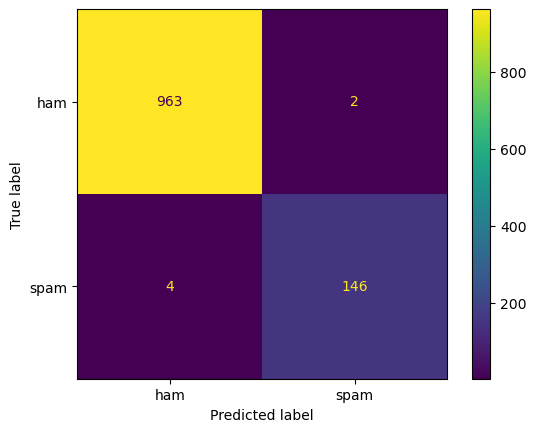

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham", "spam"])
disp.plot()
plt.show()